In [ ]:
pip install vk

In [2]:
import vk
#import webbrowser
from vk.session import requests
import json

In [3]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [4]:
import networkx as nx
import matplotlib as plt
plt.rcParams['figure.figsize'] = [50, 50]

In [ ]:
import copy

In [ ]:
token = "08df9c4e08df9c4e08df9c4e590bcf6144008df08df9c4e6b9d251ac1eb712049096851"
version = 5.126
users_idGroup = [181948702, 154308430, 152087036, 143779216, 185215592, 161594007, 472583599, 113001678, 183648122, 196404046, 
    85770676, 355133495, 137872152, 102711908, 126568936, 507184348, 458357505, 131765293, 323208790, 173792332, 343410069, 
    346034855, 255053910, 338686058, 312616596]

In [ ]:
def myfunction(datafunc, user_idfunc, framefunc,count): #Функция преобразования полученный данных формата JSON в DataFrame
  i = 0
  while count > i:
    main_id = user_idfunc #ID человека чьих друзей парсят
    id_friend = datafunc[i]['id'] #id его друзей
    first_name = datafunc[i]['first_name']#Имя 
    last_name =  datafunc[i]['last_name']#Фамилия
    new_row = {'main_id': main_id, 'id_friend': id_friend,'first_name': first_name, 'last_name': last_name}#Создаем строку с помощью которой записываем данные в DataFrame

    try:
      #Если срабатывают условия, то данные отбрасываются
    
      if datafunc[i]['deactivated'] == "banned": #Если у человека статус забанен отбрасываем
        a = "Сработало исключение - banned"
      
      if datafunc[i]['deactivated'] == "deleted": #Если у человека статус удален отбрасываем 
        b = "Сработало исключение - deleted"

    except:  
    
      try: 
        if datafunc[i]['is_closed'] == True: #Если у человека закрыта страница отбрасываем
          c = "Доступ к странице пользователя недоступен"
          #print(last_name)
        else:
          framefunc = framefunc.append(new_row, ignore_index=True) 
          #print(new_row)

      except:
        framefunc = framefunc.append(new_row, ignore_index=True)
        #print(new_row)
    
    i += 1
  #frame1 = frame1.iloc[0:0]
  #print(framefunc)
  return framefunc

In [ ]:
i = 0
countOfidFriend = len(users_idGroup) #Начинаем парсить друзей друзей
infoUser = {'main_id':[],'id_friend':[],'first_name':[],'last_name':[]}
frame1 = pd.DataFrame([infoUser])
frame1 = frame1.iloc[0:0]

while i < countOfidFriend:
  response = requests.get("https://api.vk.com/method/friends.get",
                        params={
                            "user_id": users_idGroup[i],
                            "order": "name",
                            "count": 5000,
                            "offset": 0,
                            "fields": "nickname",

                            "access_token": token,
                            "v": version
                        }
                        )
  if(response.json()):
    data = response.json()
    #изменение здесь
    #print(data)
    try:
      data1 = data['response']['items']
      #print(data1)
      count = data['response']['count']
      frame1 = myfunction(data1, users_idGroup[i], frame1, count)
      del data1
    except:
      d = "Ну и не надо"
    i += 1
frame1

,main_id,id_friend,first_name,last_name
0,181948702,442387982,ピンクの雨,カップ・カップ
1,181948702,581054682,叫张,志
2,181948702,194384429,Alexander,Gerasimov
3,181948702,430679842,Alexander,Rykalin
4,181948702,163473645,Alexander,Tsvetkov
...,...,...,...,...
3056,312616596,358526702,Valya,Novgorodova
3057,312616596,326542225,Vika,Volkanitina
3058,312616596,72207822,Viktor,Melnikov
3059,312616596,474174041,Yury,Nano


In [ ]:
idFriendsUser = frame1['id_friend']
frame2 = copy.deepcopy(frame1) #Копируем DataFrame иначе данные у 1-го также будут изменяться 
i = 0
countOfidFriend = len(frame1['id_friend']) #Начинаем парсить друзей друзей
while i < countOfidFriend:
  response = requests.get("https://api.vk.com/method/friends.get",
                        params={
                            "user_id": idFriendsUser[i],
                            "order": "name",
                            "count": 5000,
                            "offset": 0,
                            "fields": "nickname",

                            "access_token": token,
                            "v": version
                        }
                        )
  if(response.json()):
    data2 = response.json()
    #print(idFriendsUser[i])
    #print(data2)
    data3 = data2['response']['items']
    count = data2['response']['count']
    frame2 = myfunction(data3, idFriendsUser[i], frame2, count)
    del data2
    i += 1

In [ ]:
frame2

,main_id,id_friend,first_name,last_name
0,181948702,442387982,ピンクの雨,カップ・カップ
1,181948702,581054682,叫张,志
2,181948702,194384429,Alexander,Gerasimov
3,181948702,430679842,Alexander,Rykalin
4,181948702,163473645,Alexander,Tsvetkov
...,...,...,...,...
276222,214788785,202609273,Yulia,Likhachyova
276223,214788785,302190859,Yulian,Erin
276224,214788785,691362286,Yury,Morenov
276225,214788785,200366435,Zhenya,Dontsov


In [ ]:
infoUser = {'id_firstNode':[],'id_secondNode':[],'CountOfCommonFriend':[]}
frame3 = pd.DataFrame([infoUser])
frame3 = frame3.iloc[0:0] #Создаем новый DataFrame в котором будут храниться люди с общими друзьями 

countOfMainID = len(frame2.main_id.unique())#Считаем сколько уникальных id хранятся в поле main_id

i = 0
j = 0

current_firstNodeId  = frame2.main_id.unique() #Здесь хранятся id пользователей чьих друзей запишут в data1FriendFirstNode 

while countOfMainID > i:
  
  data1FriendFirstNode = frame2.loc[current_firstNodeId[i] == frame2.main_id, 'id_friend'].to_list() #Записываем друзей пользователя i-го порядка 
  countOfFirstNodeId = len(data1FriendFirstNode) #Находим количество его друзей 
  while countOfFirstNodeId > j:
    countOfCommonFriend = 0 #Создаем переменную для подсчета совпадающих друзей
    data2FriendSecondNode = frame2.loc[data1FriendFirstNode[j] == frame2.main_id, 'id_friend'].to_list() #Здесь хранятся id пользователей друзей, чтобы затем определить между ними общих
    current_SecondNodeId  = len(data2FriendSecondNode) #Находим друзей пользователя j-го порядка
    sizedata1 = len(data1FriendFirstNode) #Вычисляем количество друзей i-го пользователя
    sizedata2 = len(data2FriendSecondNode)#Вычисляем количество друзей j-го пользователя
    for ix in range(sizedata1):
      for jx in range(sizedata2):
        if data1FriendFirstNode[ix] == data2FriendSecondNode[jx]:
          countOfCommonFriend += 1
          print()

    new_row = {'id_firstNode': current_firstNodeId[i], 'id_secondNode': data1FriendFirstNode[j],'CountOfCommonFriend': countOfCommonFriend}
    frame3 = frame3.append(new_row, ignore_index=True)
    j += 1
    
  i += 1

frame4 = frame3.loc[frame3["CountOfCommonFriend"] > 0]

frame4 = frame4.drop_duplicates()
frame4

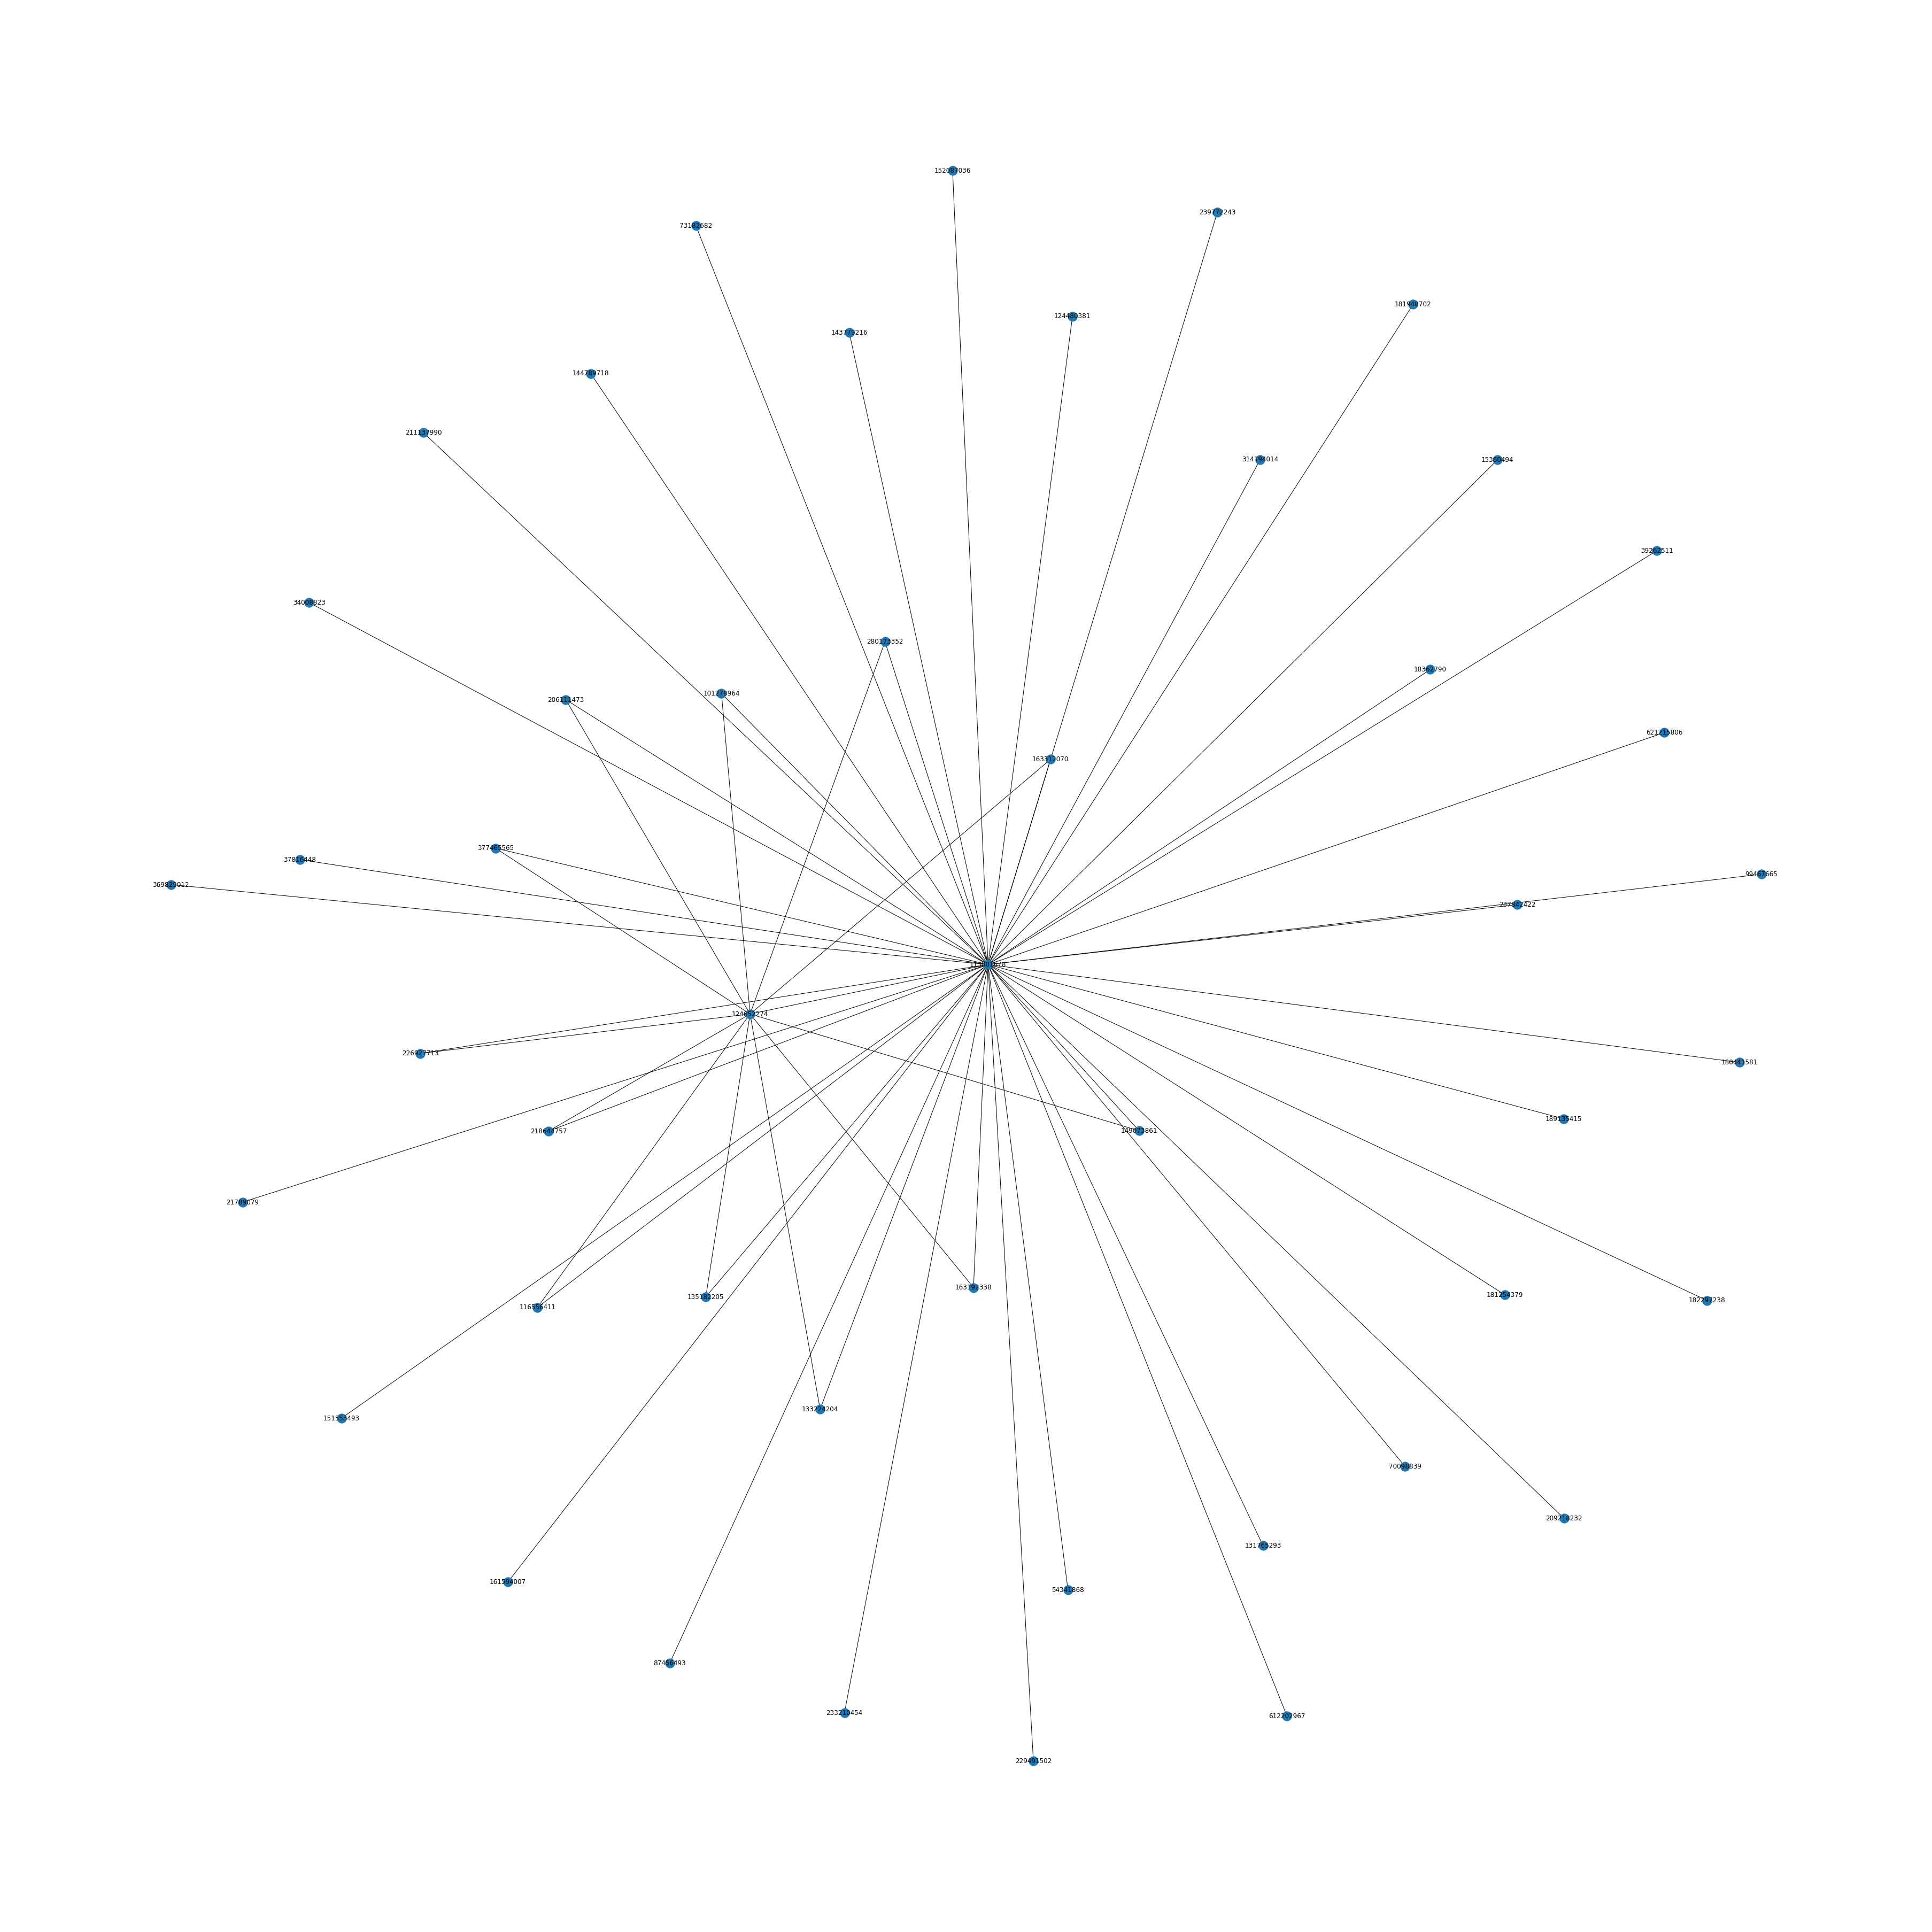

In [ ]:
G = nx.Graph()
id_firstNode = frame4.id_firstNode.to_list()
id_secondNode = frame4.id_secondNode.to_list()


sizeOfNodes = len(frame4.CountOfCommonFriend)
for ix in range(sizeOfNodes):
  G.add_edge(id_firstNode[ix],id_secondNode[ix])
  G.edges()

pos = nx.spring_layout(G,scale=40, k=0.30, iterations=20)
nx.draw(G, pos, with_labels=1)

In [ ]:
Yup = nx.Graph()
id_firstNode = frame2.main_id.to_list()
id_secondNode = frame2.id_friend.to_list()


sizeOfNodes = len(frame2.main_id)
for ix in range(sizeOfNodes):
  Yup.add_edge(id_firstNode[ix],id_secondNode[ix])
  Yup.edges()

pos = nx.spring_layout(Yup,scale=40, k=0.30, iterations=20)
nx.draw(Yup, pos, font_size=6, node_size=750, alpha=0.7, with_labels=True, edge_color='gray')

Output hidden; open in https://colab.research.google.com to view.